In [3]:

!pip install gymnasium shimmy stable-baselines3[extra] matplotlib swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376421 sha256=b31247380de4a4d3c039d012f3285591653a3e23085e081001a8fd6aea8be198
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import gymnasium as gym
import os
from datetime import datetime
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import SAC
import shutil
from google.colab import drive
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

video_folder = "/content/drive/My Drive/RL"
os.makedirs(video_folder, exist_ok=True)


timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
video_filename = f"rl-video-{timestamp}.mp4"
video_file_path = os.path.join(video_folder, video_filename)

ENV_NAME = "LunarLanderContinuous-v3"

env = RecordVideo(
    gym.make(ENV_NAME, render_mode="rgb_array", max_episode_steps=2000),
    video_folder=video_folder,
    episode_trigger=lambda episode_id: episode_id == 0
)
print(f"Video will be saved to: {video_file_path}")
print(f"Testing Environment: {ENV_NAME}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute


Video will be saved to: /content/drive/My Drive/RL/rl-video-20241211_111525.mp4
Testing Environment: LunarLanderContinuous-v3


/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [7]:

class RewardCallback(BaseCallback):
    """
    自定义回调函数，用于记录每个 episode 的奖励。
    """
    def __init__(self, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.episode_rewards = []

    def _on_step(self):
        if 'episode' in self.locals['infos'][0]:
            self.episode_rewards.append(self.locals['infos'][0]['episode']['r'])
        return True

In [9]:
model = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    batch_size=256,
    buffer_size=200000
)



reward_callback = RewardCallback()


model.learn(total_timesteps=200000, log_interval=10, callback=reward_callback)


model.save(f"sac_{ENV_NAME}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 130      |
|    ep_rew_mean     | -227     |
| time/              |          |
|    episodes        | 10       |
|    fps             | 59       |
|    time_elapsed    | 21       |
|    total_timesteps | 1303     |
| train/             |          |
|    actor_loss      | 5.89     |
|    critic_loss     | 22.6     |
|    ent_coef        | 0.712    |
|    ent_coef_loss   | -0.851   |
|    learning_rate   | 0.0003   |
|    n_updates       | 1202     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 185      |
|    ep_rew_mean     | -215     |
| time/              |          |
|    episodes        | 20       |
|    fps             | 59       |
|    time_elapsed    | 62       |
|    total_timesteps | 3700     |
| train/             |          |
|    actor_loss      | 9.52     |
|    critic_loss     | 12.3     |
|    ent_coef 

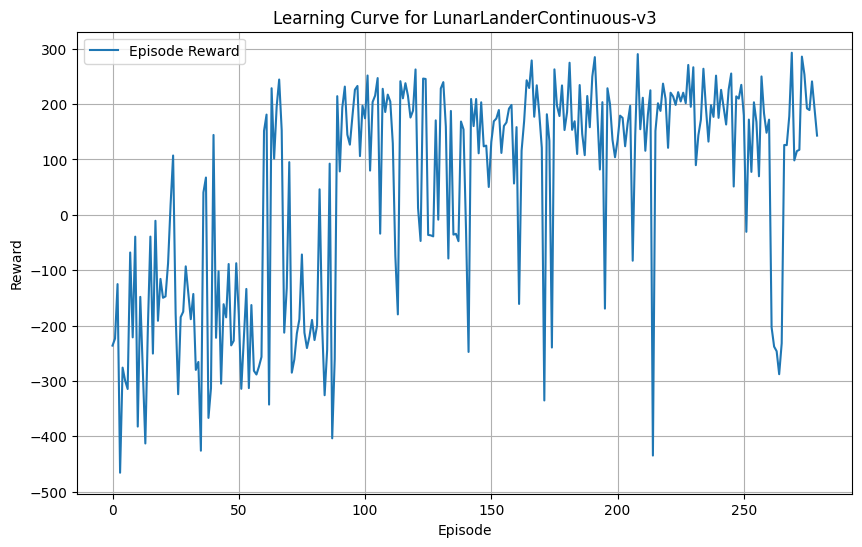

Learning curve saved to: /content/drive/My Drive/RL/learning_curve2.png


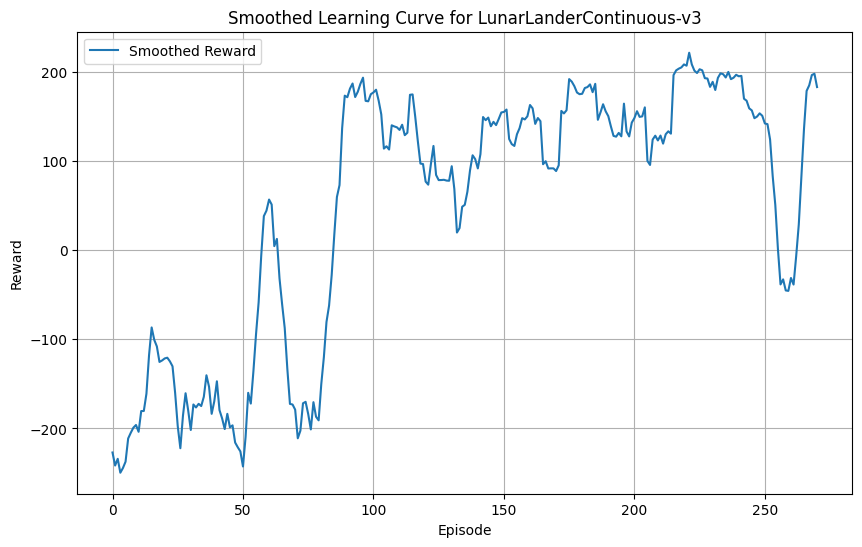

In [10]:

plt.figure(figsize=(10, 6))
plt.plot(reward_callback.episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title(f'Learning Curve for {ENV_NAME}')
plt.legend()
plt.grid()
video_folder = "/content/drive/My Drive/RL"
save_path = f"{video_folder}/learning_curve2.png"
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Learning curve saved to: {save_path}")



def smooth(data, window_size):
    """滑动平均平滑曲线"""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_rewards = smooth(reward_callback.episode_rewards, window_size=10)

plt.figure(figsize=(10, 6))
plt.plot(smoothed_rewards, label='Smoothed Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title(f'Smoothed Learning Curve for {ENV_NAME}')
plt.legend()
plt.grid()
plt.show()



In [15]:

model = SAC.load(f"sac_{ENV_NAME}")
obs, info = env.reset()

for _ in range(2000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    if done or truncated:
        break

env.close()


video_files = sorted([f for f in os.listdir(video_folder) if f.endswith(".mp4")])
if video_files:
    original_video_path = os.path.join(video_folder, video_files[-1])
    print("Generated video path (default):", original_video_path)


    shutil.move(original_video_path, video_file_path)
    print("Renamed video path:", video_file_path)
else:
    print("No video files found in folder.")


Generated video path (default): /content/drive/My Drive/RL/rl-video-episode-0.mp4
Renamed video path: /content/drive/My Drive/RL/rl-video-20241210_010129.mp4


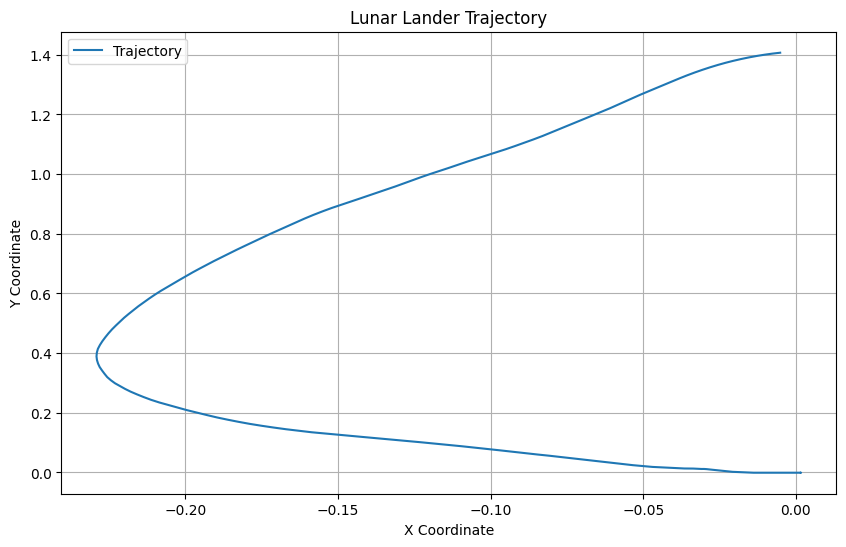

In [24]:
import matplotlib.pyplot as plt
import numpy as np

obs, info = env.reset()
states = []


for _ in range(2000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)

    x, y = obs[0], obs[1]
    states.append((x, y))
    if done or truncated:
        break

states = np.array(states)

plt.figure(figsize=(10, 6))
plt.plot(states[:, 0], states[:, 1], label="Trajectory")
plt.title("Lunar Lander Trajectory")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.grid()
plt.show()
